In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os

In [32]:
script_dir = os.path.abspath('')

In [24]:
def plot_fund_flow_line(plt, ticker):
    fund_flow_df = pd.read_excel(os.path.join(script_dir, f"data\{ticker}_fund_flow_data.xlsx"))
    fund_flow_df["asOf"] = pd.to_datetime(fund_flow_df["asOf"])

    plt.figure(figsize=(10, 6))
    plt.plot(
        fund_flow_df["asOf"],
        fund_flow_df["value"],
        marker="o",
        color="b",
        label="Fund Movement",
    )
    plt.axhline(0, color="gray", linewidth=0.5)
    plt.title("Daily Fund Inflow and Outflow for VCLT")
    plt.xlabel("Date")
    plt.ylabel("Fund Movement ($)")
    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [35]:
def plot_fund_flow_ticks(ticker, tick_freq):
    fund_flow_df = pd.read_excel(os.path.join(script_dir, f"data\{ticker}_fund_flow_data.xlsx"))
    fund_flow_df["asOf"] = pd.to_datetime(fund_flow_df["asOf"])

    tick_freq = 5
    dates = fund_flow_df['asOf']
    mask = dates.index % tick_freq == 0  
    selected_dates = dates[mask]

    fig, ax = plt.subplots(figsize=(17, 8))

    for index, row in fund_flow_df.iterrows():
        if row["value"] > 0:
            color = "green"
            dx = 0
            dy = row["value"]
            y = 0  
        else:
            color = "red"
            dx = 0
            dy = -row["value"]
            y = row["value"]  

        # Adding an arrow to the plot
        ax.arrow(
            row["asOf"],  
            y,
            dx,
            dy,
            head_width=0.15,  
            head_length=abs(dy) * 0.3,  
            fc=color,  
            ec=color,
        ) 
        
    ax.set_title(f"Daily Fund Inflow and Outflow for {ticker} with Directional Indicators")
    ax.set_xlabel("Date")
    ax.set_ylabel("Fund Movement ($1e7)")

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    # ax.set_xticks(fund_flow_df["asOf"])
    ax.set_xticks(selected_dates)

    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle="--", linewidth=0.5)

    ax.axhline(0, color="black", linewidth=0.6)

    # Adjusting the layout and showing the plot
    plt.tight_layout()
    plt.show()

### (10/16/2023) Inflow to Long Duration Treasury ETFs

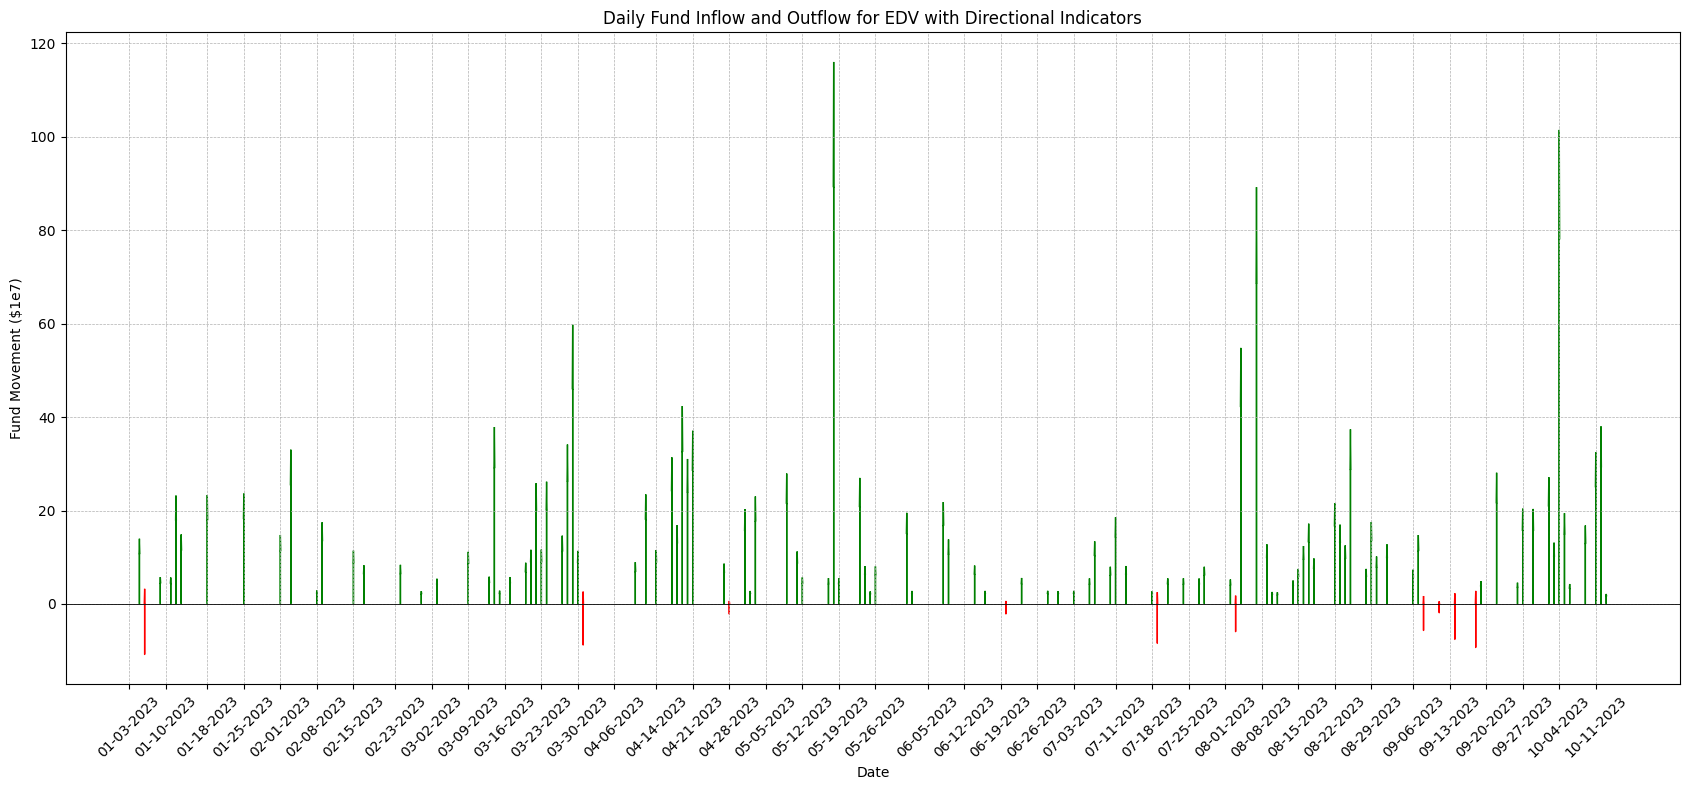

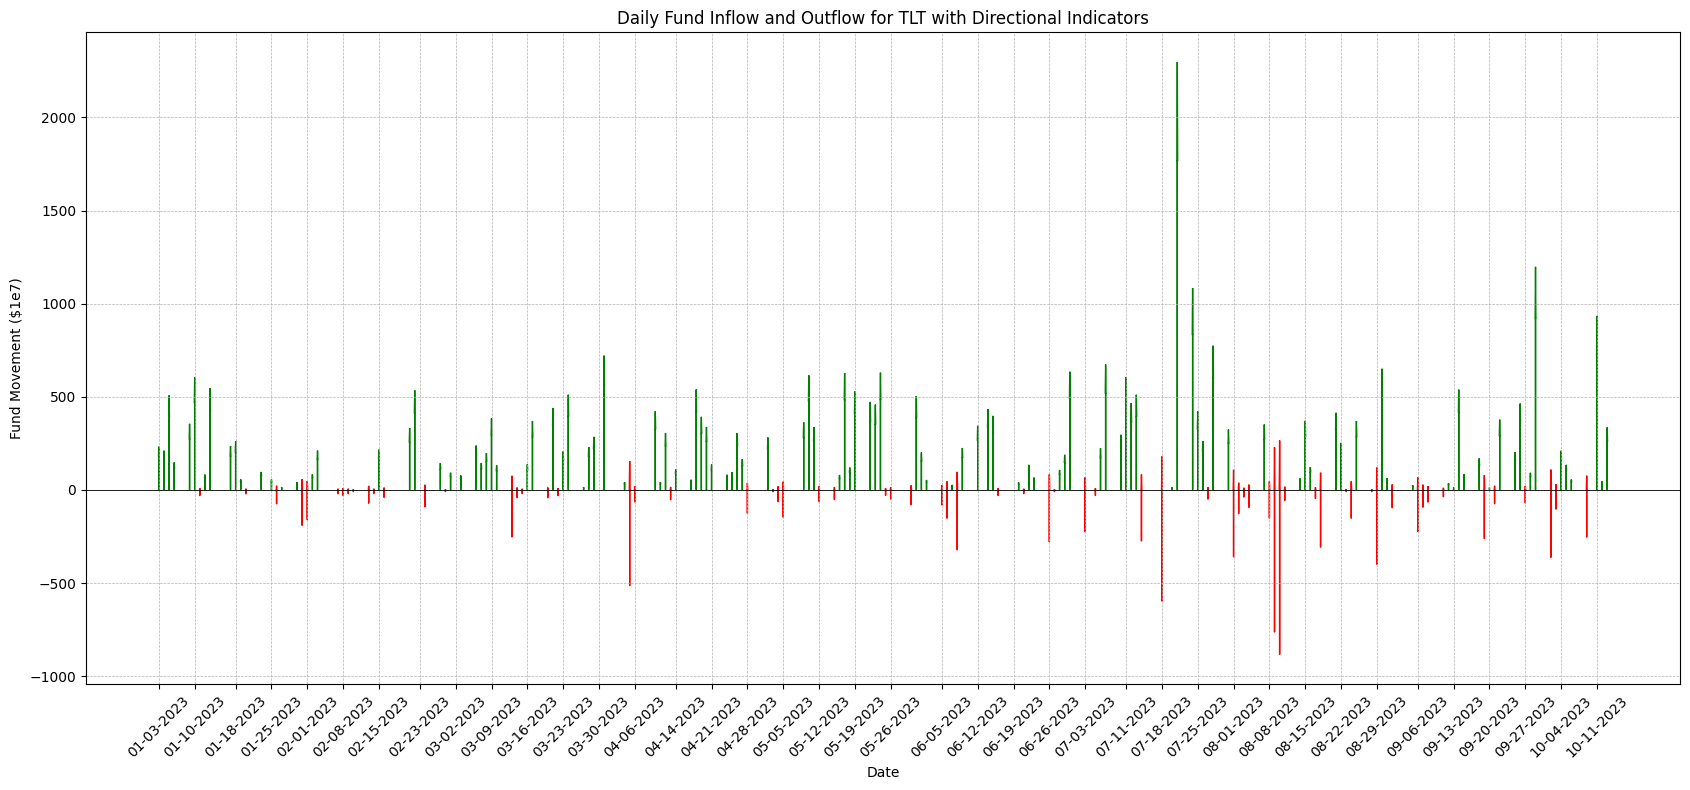

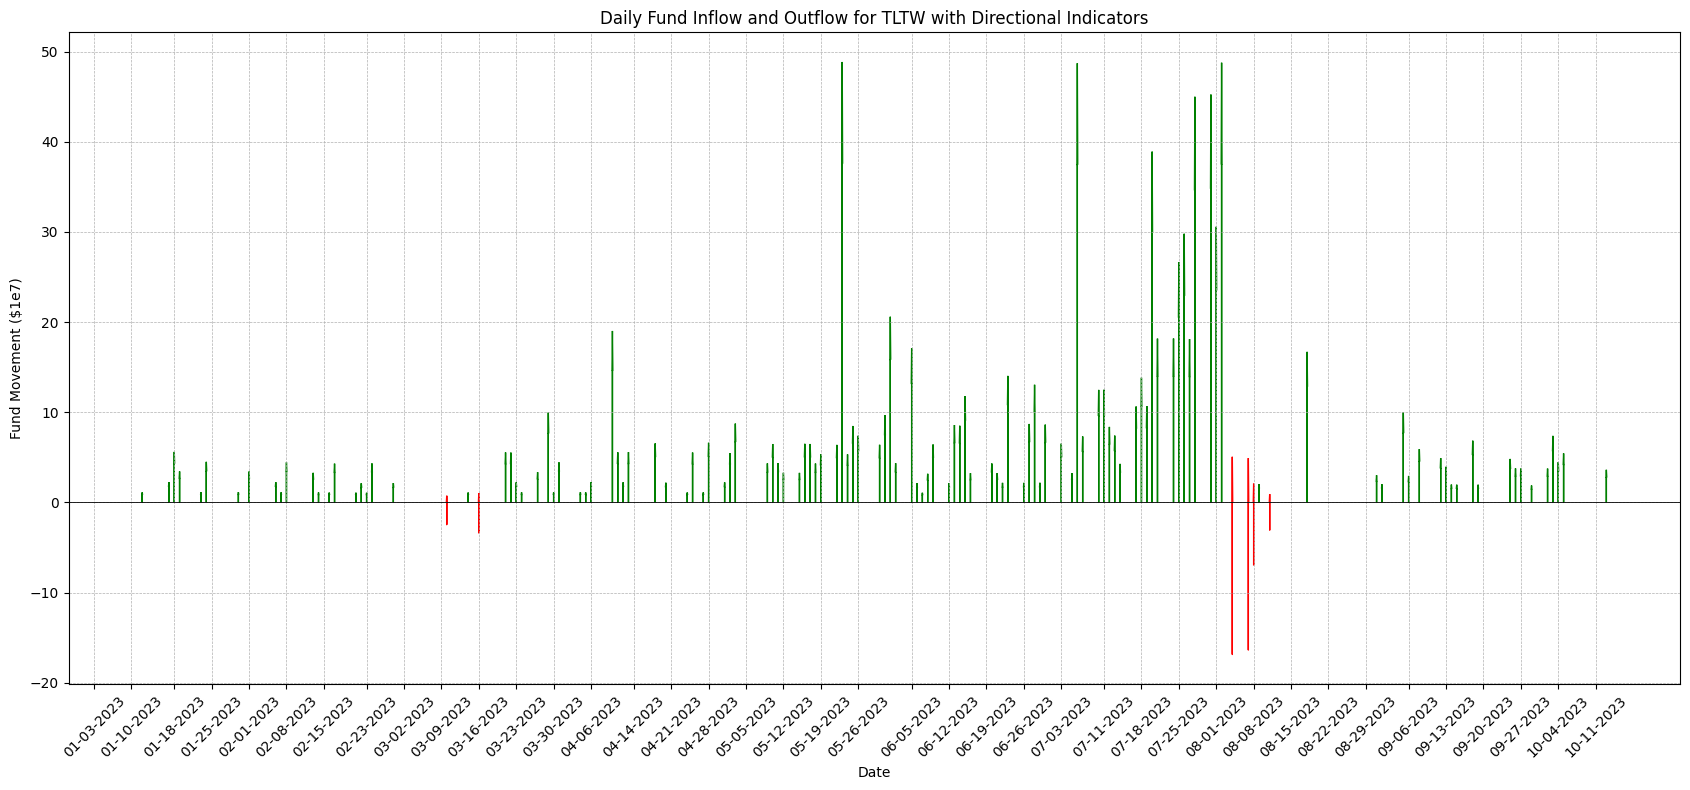

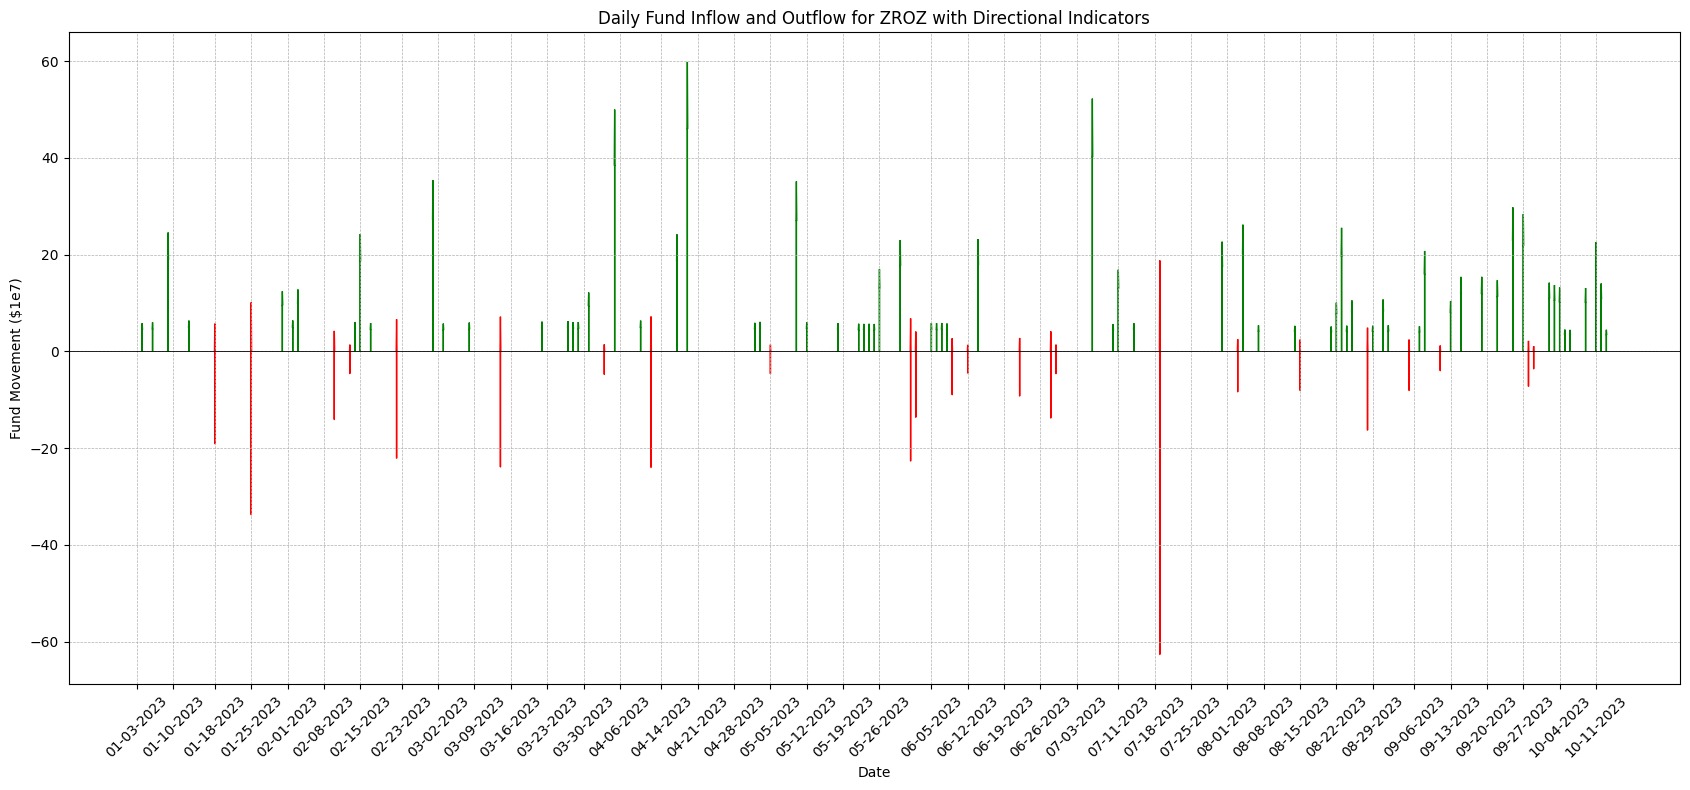

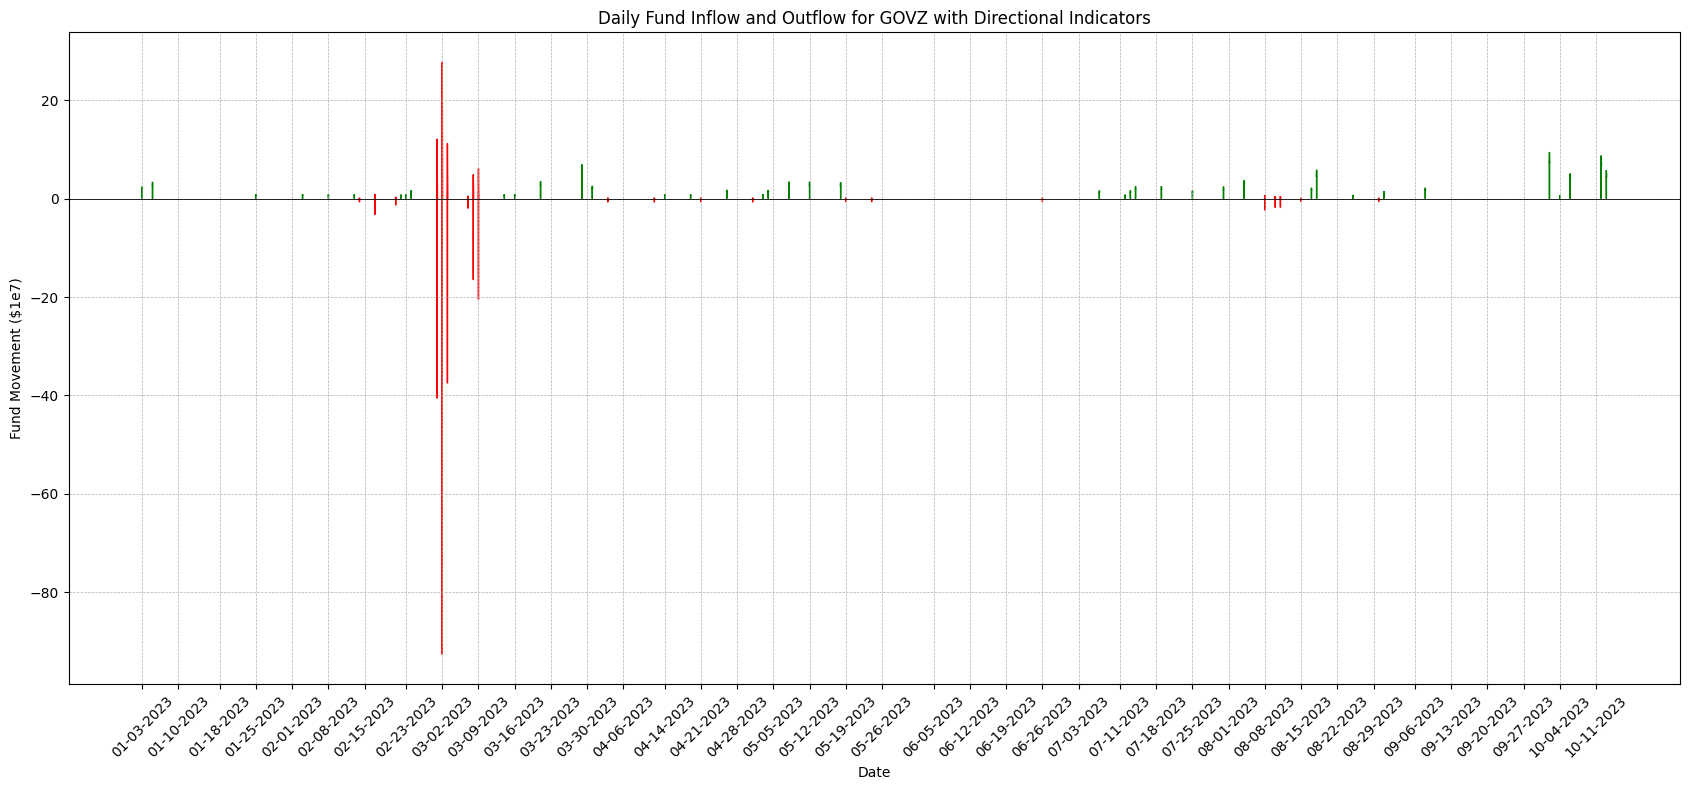

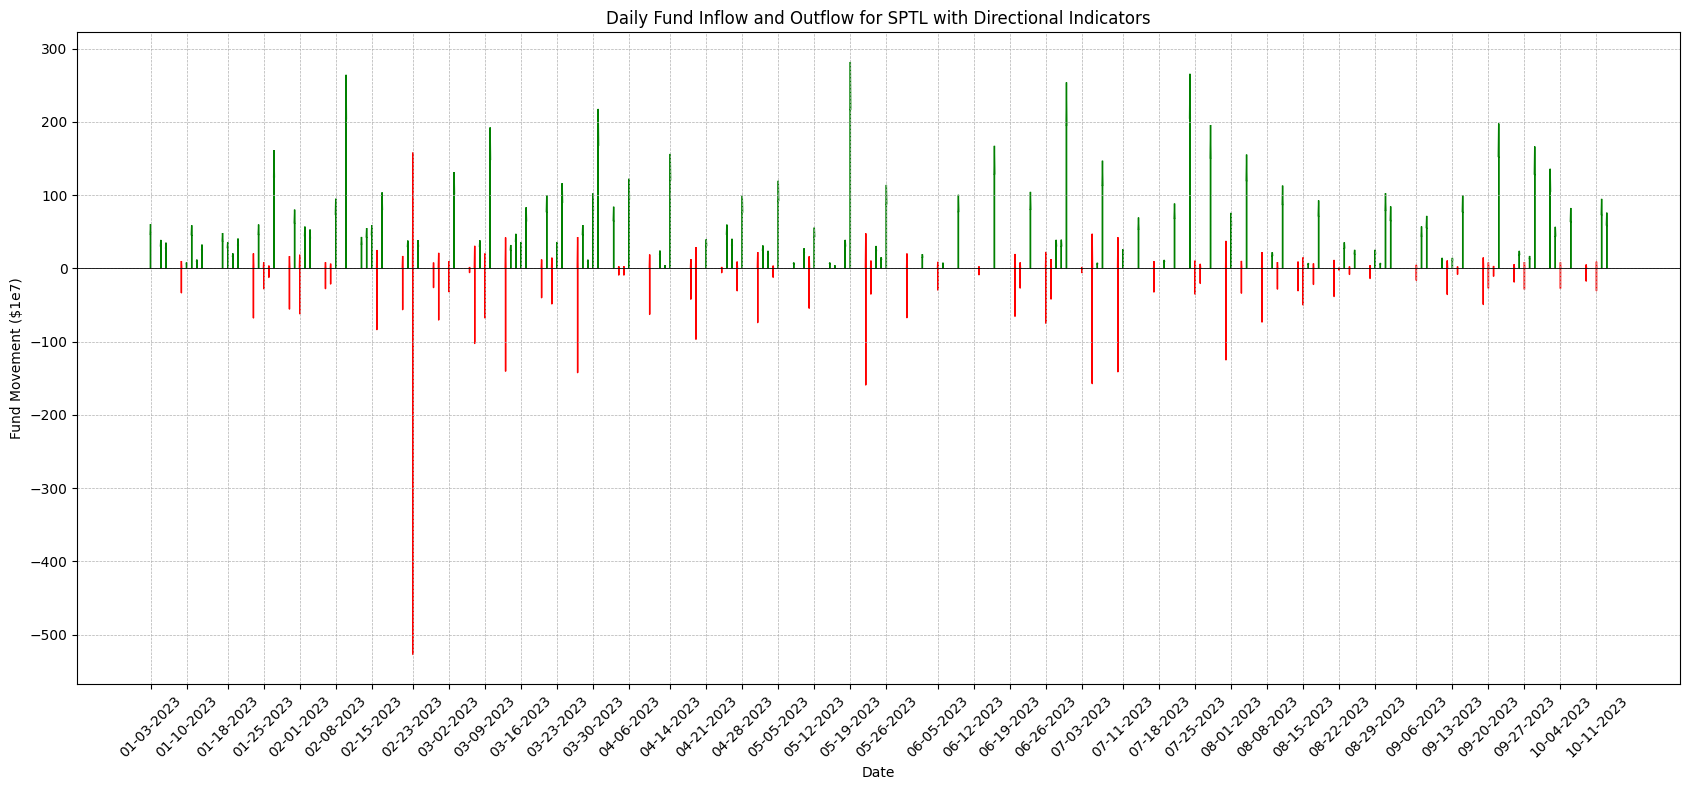

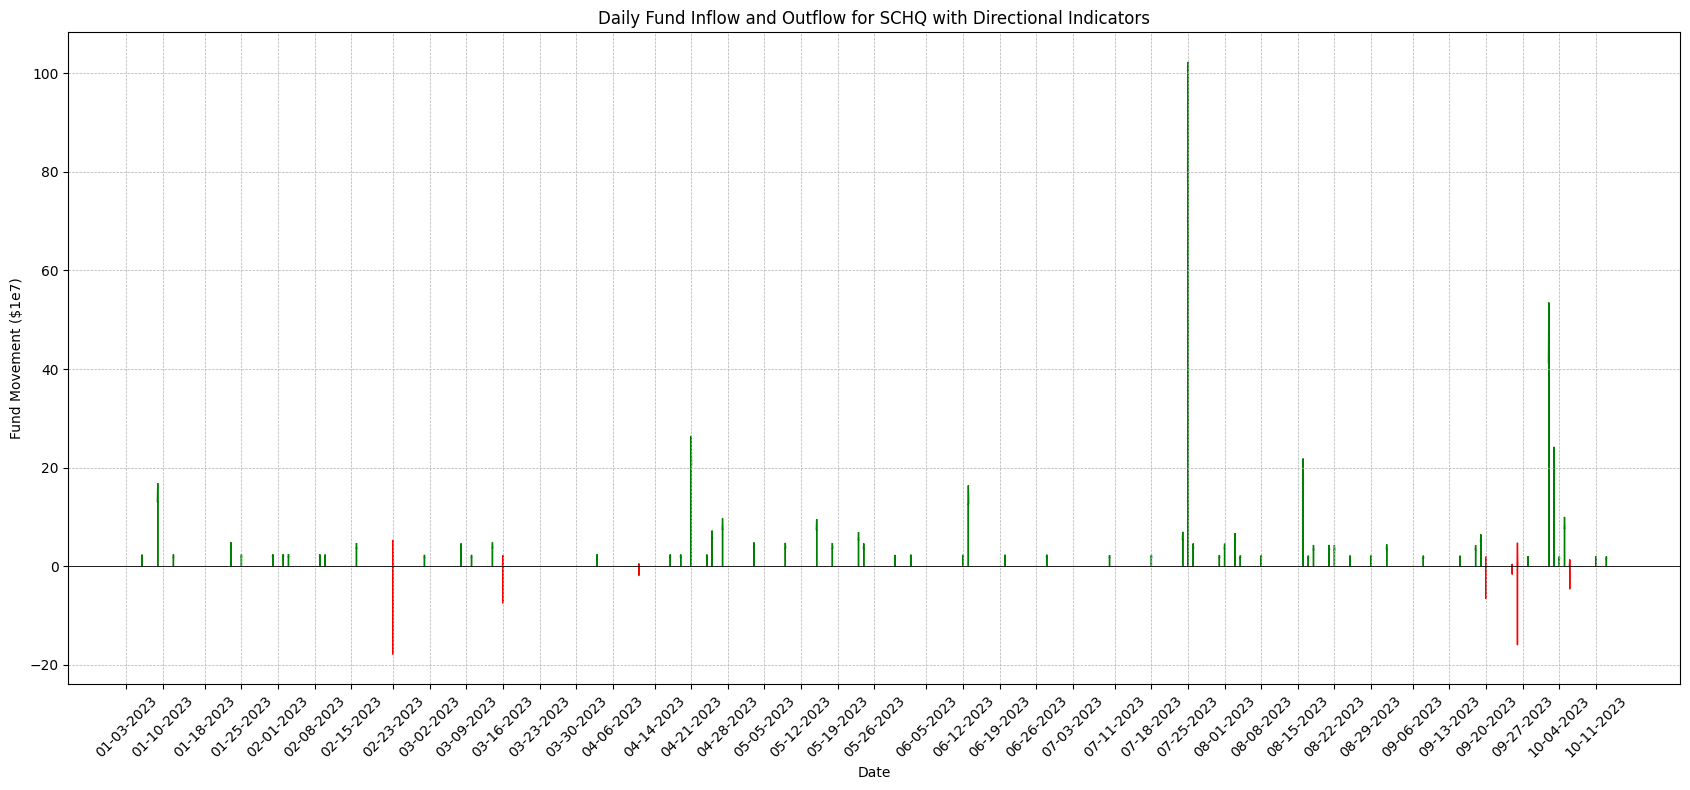

In [39]:
plot_fund_flow_ticks('EDV', 5)
plot_fund_flow_ticks('TLT', 5)
plot_fund_flow_ticks('TLTW', 5)
plot_fund_flow_ticks('ZROZ', 5)
plot_fund_flow_ticks('GOVZ', 5)
plot_fund_flow_ticks('SPTL', 5)
plot_fund_flow_ticks('SCHQ', 5)
